# Setup

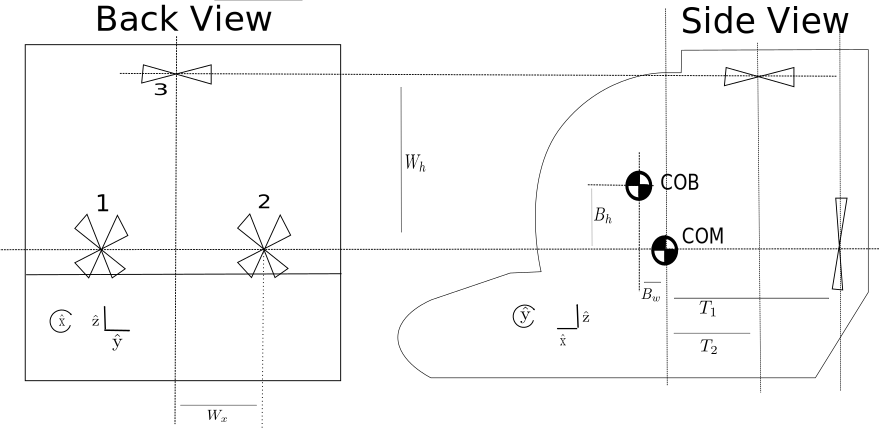

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import sympy.physics.mechanics as me
from pydy.system import System
from pydy.viz import Cylinder, Plane, VisualizationFrame, Scene
from sympy import sin, cos, symbols, solve
from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
from IPython.display import SVG
SVG(filename='openrov2.svg')

In [2]:
%matplotlib nbagg

In [3]:
me.init_vprinting(use_latex='mathjax')

# Define Variables

constants:

- $m_A$: Mass of the Rov.
- $T_1$: Distance from COM to back thruster axis.
- $T_2$: Distance from COM to upper thruster axis.
- $W_x$: distance from center axis to back thruster axis.
- $W_h$: distance from center axis to upper thruster.
- $B_h$: the z messure of COB (center of bouyency) distance from COG (center of gravity) 
- $B_h$: the x messure of COB distance from COG.

In [4]:
# Inertial Reference Frame
N = me.ReferenceFrame('N')

# Define a world coordinate origin
O = me.Point('O')
O.set_vel(N, 0)

In [5]:
rot = list(me.dynamicsymbols('r0:3'))
#rot = list(symbols('r0:3'))
drot = list(me.dynamicsymbols('dr0:3'))
x = list(me.dynamicsymbols('v0:3')) # Coordinates of robot in World Frame
dx = list(me.dynamicsymbols('dv0:3'))
kin_diff=Matrix(x+rot).diff()-Matrix(dx+drot)
kin_diff

⎡-dv₀ + v₀̇⎤
⎢          ⎥
⎢-dv₁ + v₁̇⎥
⎢          ⎥
⎢-dv₂ + v₂̇⎥
⎢          ⎥
⎢-dr₀ + r₀̇⎥
⎢          ⎥
⎢-dr₁ + r₁̇⎥
⎢          ⎥
⎣-dr₂ + r₂̇⎦

In [ ]:
#xxx = me.dynamicsymbols('xxx')
#from sympy import *
#eval(sm.srepr(kin_diff))
#import pickle
#pickle.dump(xxx,open('/tmp/forcing_vector.pkl','wb'))

In [6]:
# Constants for the Robot Body
Wx = symbols('W_x')                                     # 2*w is the width between thrusters
Wh = symbols('W_h')                                    
T1 = symbols('T_1')                                     # Distance between thruster base and center of mass
T2 = symbols('T_2')                                     
Bh = symbols('B_h')                                     
Bw = symbols('B_w')                                     

m_b = symbols('m_b')                                 # Mass of the body
v_b = symbols('v_b') # Volume of the body
mu = symbols('\mu') #drag
mu_r = symbols('\mu_r') #rotational drag
g = symbols('g')
I = list(symbols('Ixx, Iyy, Izz'))             # Moments of inertia of body


In [7]:
# Robot Reference Frame
Rz=N.orientnew('R_z', 'Axis', (rot[2], N.z))
Rz.set_ang_vel(N,drot[2]*N.z)

Rx=Rz.orientnew('R_x', 'Axis', (rot[0], Rz.x))
Rx.set_ang_vel(Rz,drot[0]*Rz.x)

R=Rx.orientnew('R', 'Axis', (rot[1], Rx.y))
R.set_ang_vel(Rx,drot[1]*Rx.y)

#### adding dumping Torqe for each rotation
T_z=(R,-drot[2]*N.z*mu_r) #rotaional dumping Torqe
T_x=(R,-drot[0]*Rz.x*mu_r) #rotaional dumping Torqe
T_y=(R,-drot[1]*Rx.y*mu_r) #rotaional dumping Torqe

# Center of mass of body
COM = O.locatenew('COM', x[0]*N.x + x[1]*N.y + x[2]*N.z)

# Set the velocity of COM
COM.set_vel(N, dx[0]*N.x + dx[1]*N.y + dx[2]*N.z)

#center of bouyency
COB = COM.locatenew('COB', R.x*Bw+R.z*Bh)
COB.v2pt_theory(COM, N, R);
R.ang_vel_in(N)

dr₁ r_x_y + dr₀ r_z_x + dr₂ n_z

In [8]:
# Calculate inertia of body
Ib = me.inertia(R, *I)
# Create a rigid body object for body
Body = me.RigidBody('Body', COM, R, m_b, (Ib, COM))


In [9]:
# Points of thrusters
L1 = COM.locatenew('L_1', -R.x*T1+Wx*R.y)
L2 = COM.locatenew('L_2', -R.x*T1-Wx*R.y)
L3 = COM.locatenew('L_3', -R.x*T2-Wh*R.z)

# Set the velocity of points 
L1.v2pt_theory(COM, N, R)
L2.v2pt_theory(COM, N, R)
L3.v2pt_theory(COM, N, R);


## Calculating hydrodynamic drag

under sphire assumption and ignoring inertia forces

$F_{D}\,=\,{\tfrac {1}{2}}\,\rho \,v^{2}\,C_{D}\,A$

https://en.wikipedia.org/wiki/Drag_(physics)

we define $\mu$ as:

$\mu=\,{\tfrac {1}{2}}\,\rho \,C_{D}\,A$

then:

$F_{D}\,=\mu \,v^{2}$

In [10]:
#dCw=Cw.diff()
v=N.x*dx[0]+N.y*dx[1]+N.z*dx[2]
Fd=-v.normalize()*v.magnitude()**2*mu
Fd

        ____________________                   ____________________
       ╱    2      2      2                   ╱    2      2      2
-\mu⋅╲╱  dv₀  + dv₁  + dv₂  ⋅dv₀ n_x + -\mu⋅╲╱  dv₀  + dv₁  + dv₂  ⋅dv₁ n_y +

        ____________________
       ╱    2      2      2
-\mu⋅╲╱  dv₀  + dv₁  + dv₂  ⋅dv₂ n_z

In [11]:
#rotational drags
#Fr=-R.ang_vel_in(R_static)*mu
#Fr=(N,-drot[2]**2*N.z*mu),-drot[0]**2*Rz.x-drot[1]**2*Rx.y
#Fr=Fr*mu
#Fr

In [12]:
#thrust forces symbols
F1, F2, F3 = symbols('f_1, f_2, f_3') 
Fg = -N.z *m_b * g
Fb = N.z * v_b * 1e3 *g #whight of 1m^3 water in kg (MKS units)

In [13]:
kane = me.KanesMethod(N, q_ind=x+rot, u_ind=dx+drot, kd_eqs=kin_diff)

In [14]:
bodies = (Body,)
loads = (
    (L1, F1 * R.x),
    (L2, F2 * R.x),
    (L3, F3 * R.z), 
    (COM, Fg ), 
    (COB, Fb ), 
    (COM, Fd ),
    T_x,
    T_y,
    T_z
    )

fr, frstar = kane.kanes_equations(loads=loads, bodies=bodies)

In [15]:
mu_r

\muᵣ

In [16]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

⎡1  0  0  0  0  0   0    0    0                    0                         0
⎢                                                                             
⎢0  1  0  0  0  0   0    0    0                    0                         0
⎢                                                                             
⎢0  0  1  0  0  0   0    0    0                    0                         0
⎢                                                                             
⎢0  0  0  1  0  0   0    0    0                    0                         0
⎢                                                                             
⎢0  0  0  0  1  0   0    0    0                    0                         0
⎢                                                                             
⎢0  0  0  0  0  1   0    0    0                    0                         0
⎢                                                                             
⎢0  0  0  0  0  0  m_b   0    0                    0

In [17]:
forcing_vector = trigsimp(kane.forcing_full)

In [18]:
#open('/tmp/mass_matrix.srepr','wb').write(mass_matrix)


In [19]:
coordinates = tuple(x+rot)
coordinates

(v₀, v₁, v₂, r₀, r₁, r₂)

In [20]:
speeds = tuple(dx+drot)
speeds

(dv₀, dv₁, dv₂, dr₀, dr₁, dr₂)

In [21]:
specified = (F1, F2, F3)
constants = [Wx,Wh,T1,T2,Bh,Bw,m_b,v_b,mu,mu_r,g]+I

In [34]:
open('./forcing_vector.srepr','wb').write(srepr((\
                                                    forcing_vector,
                                                   coordinates,
                                                    mass_matrix,
                                                   speeds,
                                                    constants,
                                                   specified,
                                                   )).encode())


16129

In [35]:
(forcing_vector,\
coordinates,
mass_matrix,
speeds,
constants,
specified)=eval(open('./forcing_vector.srepr','rb').read())


In [24]:
right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [25]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(12,)
        The state vector is ordered as such:
            - v0(t)
            - v1(t)
            - v2(t)
            - r0(t)
            - r1(t)
            - r2(t)
            - dv0(t)
            - dv1(t)
            - dv2(t)
            - dr0(t)
            - dr1(t)
            - dr2(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(3,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of 

In [26]:
x0 = np.zeros(12)
#MKS units
#constants = [Wx,Wh,T1,T2,Bh,Bw,m_b,v_b,mu,g]+I
numerical_constants = np.array([
                            0.1,  # Wx [m]
                            0.15,  # Wh [m]
                            0.1,  # T1 [m]
                            0.05,  # T2 [m]
                            0.08,  # Bh [m]
                            0.01,  # Bw [m]
                            1.0,  # m_b [kg]
                            0.001 ,  # v_b [M^3]
                            0.3,  # mu
                            0.2,  # mu_r
                            9.8,  # g MKS
                            0.5,  # Ixx [kg*m^2]
                            0.5,  # Iyy [kg*m^2]
                            0.5,  # Izz [kg*m^2]
                               ]
                            ) 

In [27]:
#args = {'constants': numerical_constants,
numerical_specified=[0.8,0.5,0]
frames_per_sec = 60.0
final_time = 40.0

t = np.linspace(0.0, final_time, int(final_time * frames_per_sec))

In [28]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.3  ,  0.   ,
        0.   ,  0.   , -0.196, -0.06 ])

In [29]:
def controller(x, t):
    if t<20:
        #return [0.8,0.5,0]
        return [0.0,0.0,0]
    else:
        return [-0.8,-0.5,0]
#def controller(x, t):
#    return [0.0,0.0,0]
y = odeint(right_hand_side, x0, t, args=(controller, numerical_constants))

#y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))
y.shape

(2400, 12)

<IPython.core.display.Javascript object>


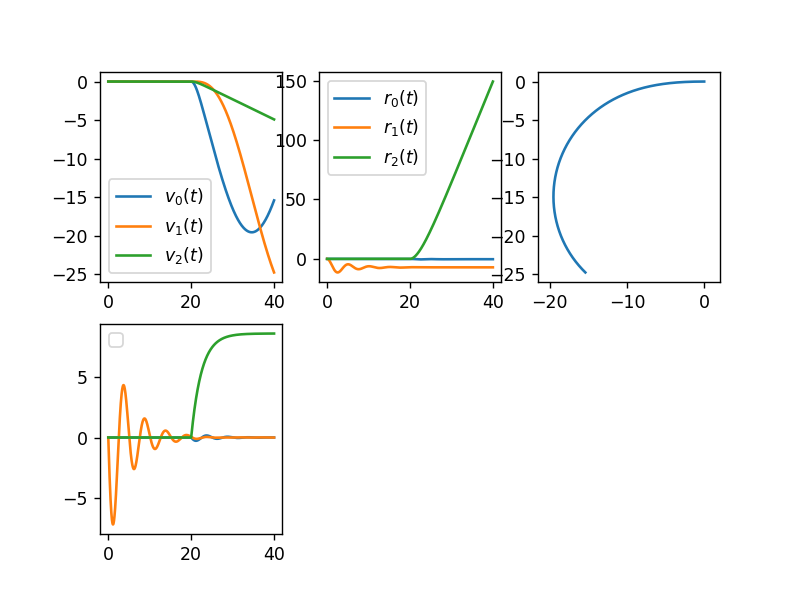

In [30]:
def plot():
    plt.figure()
    #plt.plot(sys.times, np.rad2deg(x[:, :3]))
    plt.subplot(2,3,1)
    #plt.plot(t, np.rad2deg(y[:, 0]))
    plt.plot(t, y[:, :3])
    plt.legend([latex(s, mode='inline') for s in coordinates[:3]])
    plt.subplot(2,3,2)
    plt.plot(t, np.rad2deg(y[:, 3:6]))
    plt.legend([latex(s, mode='inline') for s in coordinates[3:6]])
    plt.subplot(2,3,3)
    plt.plot(y[:,0],y[:,1])
    plt.axis('equal')
    plt.subplot(2,3,4)
    plt.plot(t, np.rad2deg(y[:, 9:12]))
    plt.legend([latex(s, mode='inline') for s in coordinates[9:12]])
plot()

# another method

In [31]:
x0 = np.zeros(12)
xx=x0
y=[]
for ct in t:
    x_dot=right_hand_side(xx, ct, controller, numerical_constants)
    y.append(xx)
    xx=xx+x_dot*1/frames_per_sec
y=np.array(y)
y.shape

(2400, 12)

<IPython.core.display.Javascript object>


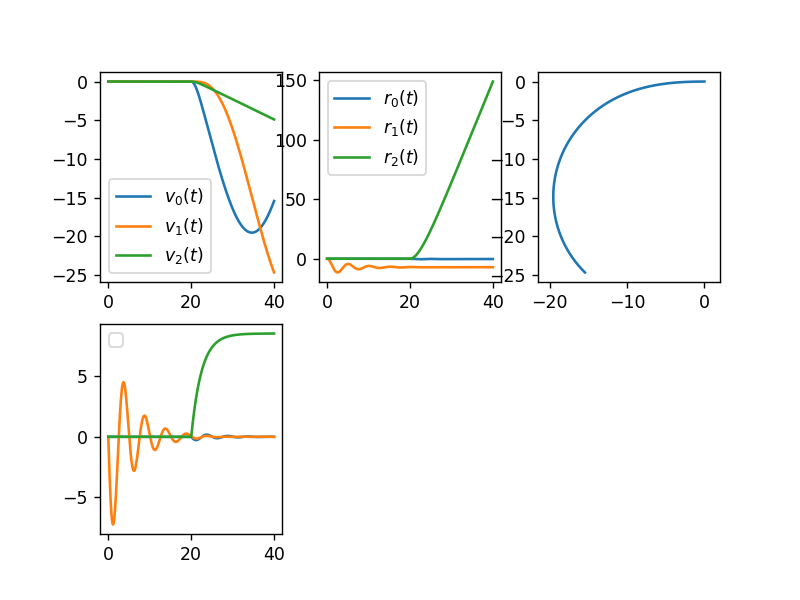

In [32]:
plot()